# Authorship Attribution Petition

Sam McDowell \
12/5/2025

## Custom Model

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

In [3]:
# Load data
data_path = "./data/features.csv"
df = pd.read_csv(data_path, index_col=0)

# Select numeric columns only
numeric_df = df.select_dtypes(include=["number"]).copy()
numeric_df = numeric_df.drop(["word_count"], axis=1)

### Visualizations

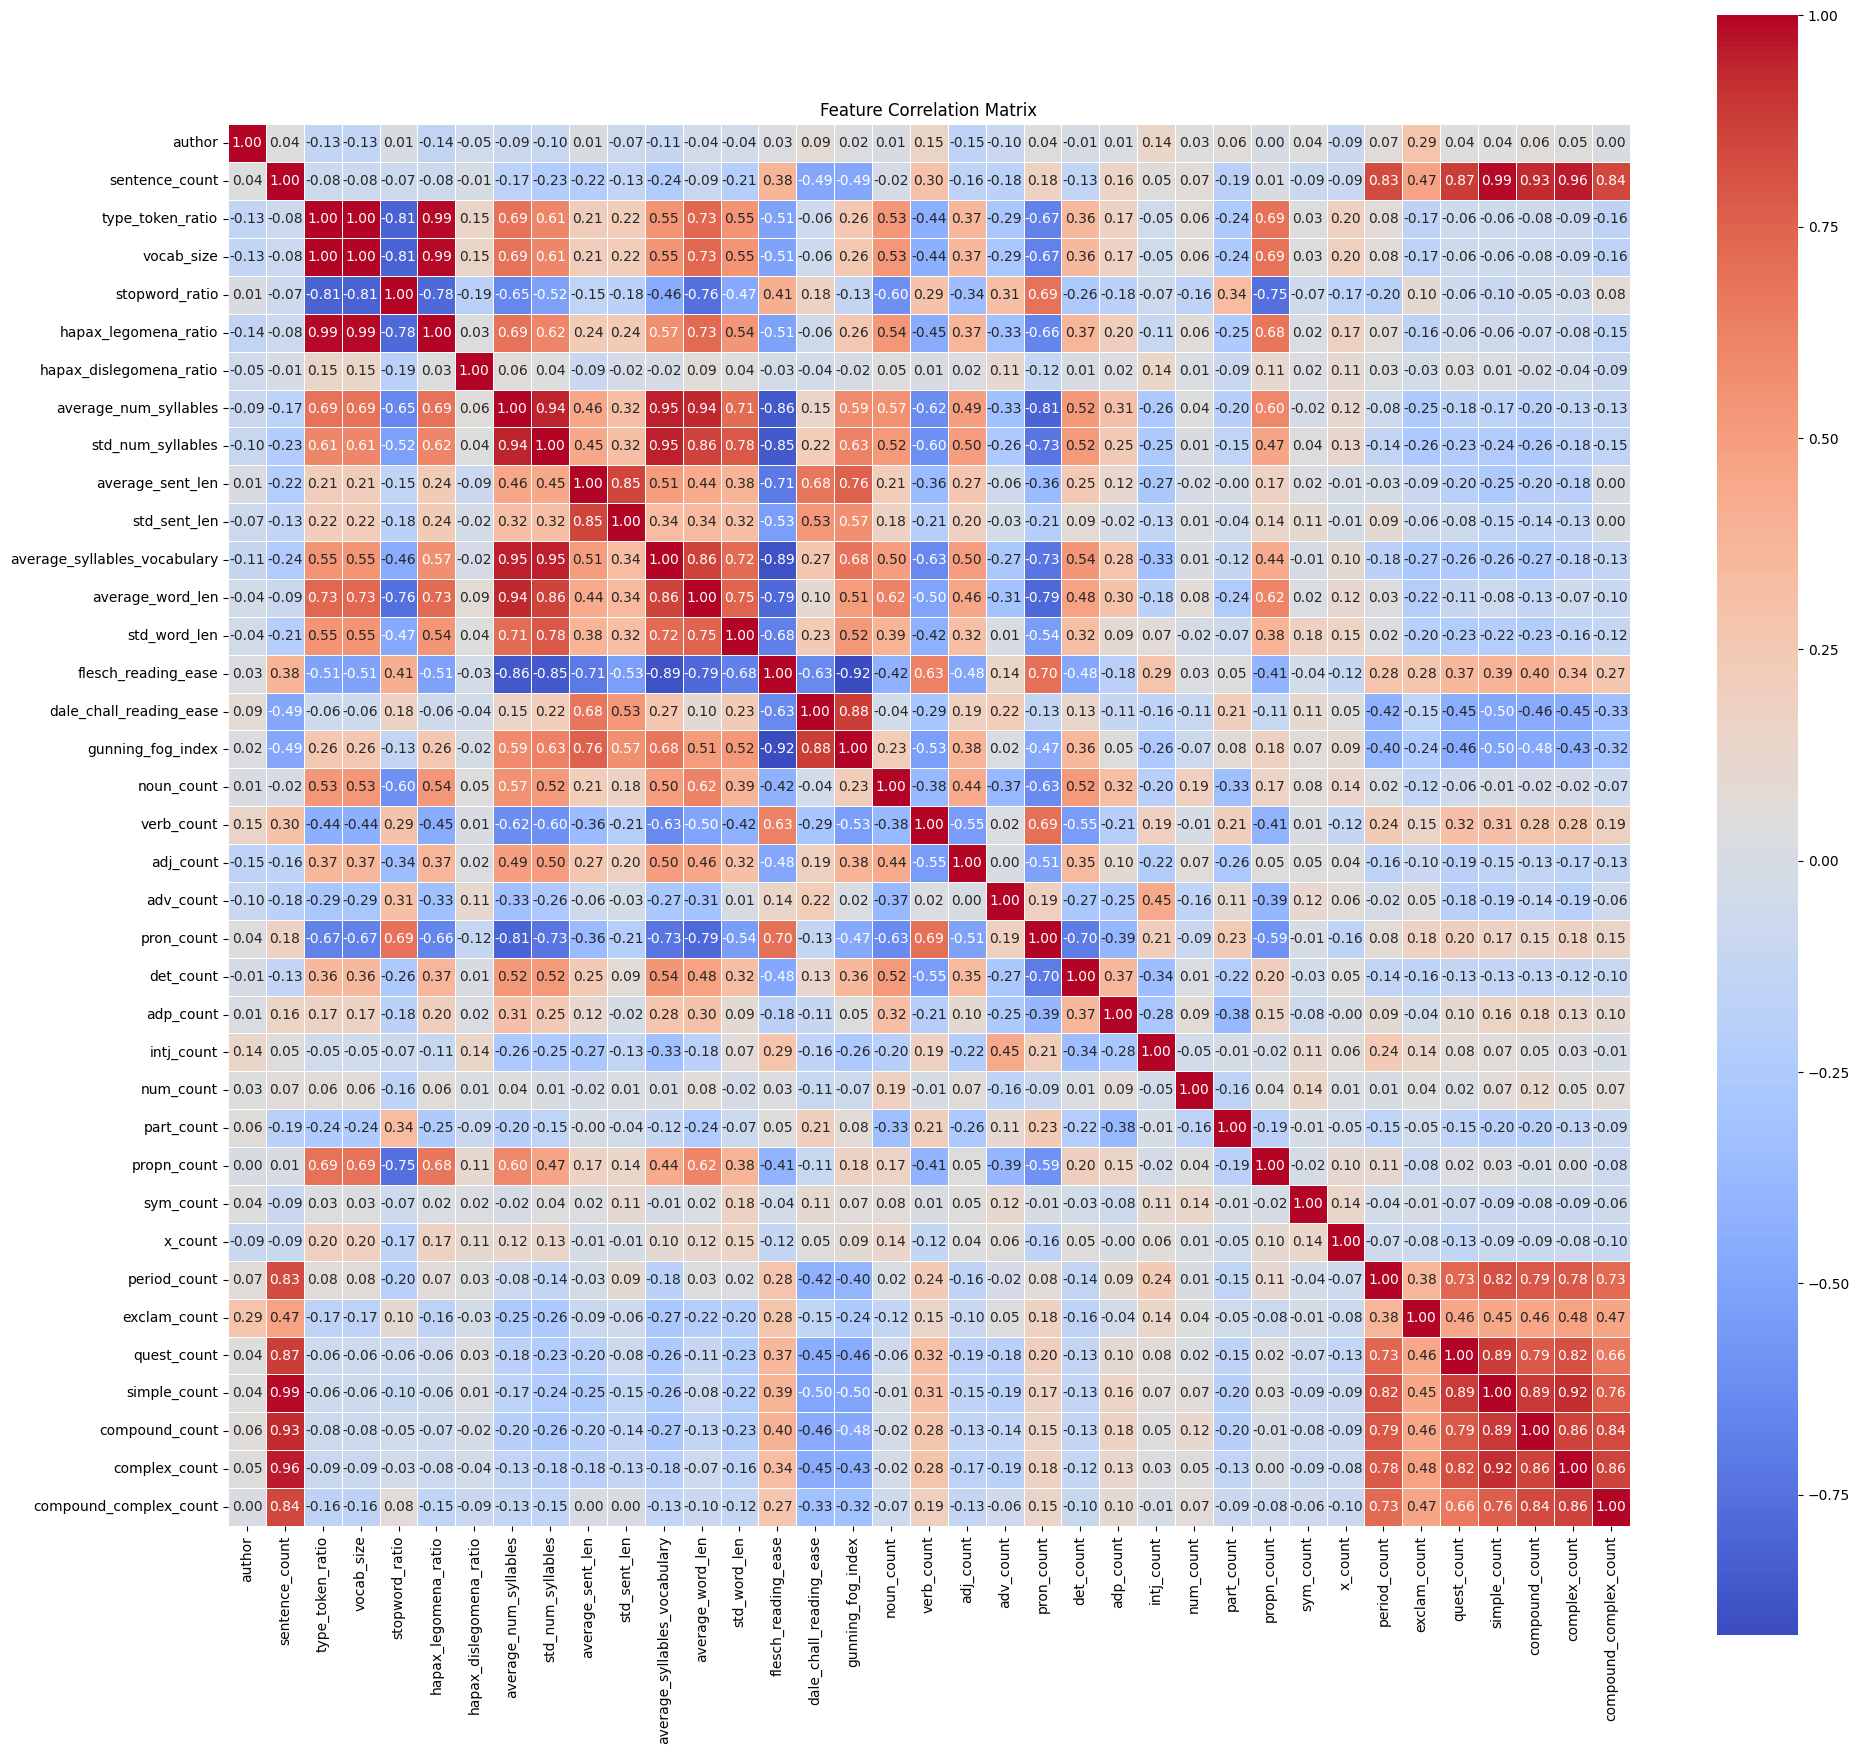

In [4]:
# Compute correlation
corr = numeric_df.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=.5,
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("output/correl.png")
plt.show()

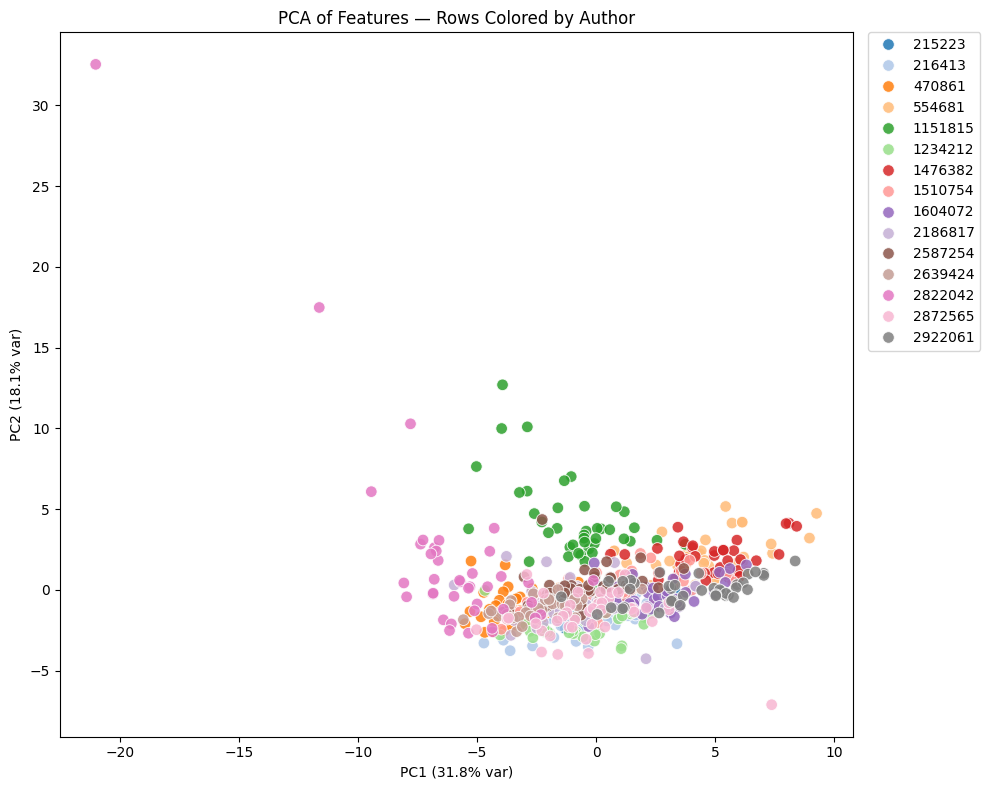

In [5]:
# -----------------------------
# Prepare data
# -----------------------------
labels = df["author"].astype(str)

# Fill missing values
X = numeric_df.fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# PCA
# -----------------------------
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=numeric_df.index)
pc_df["author"] = labels

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    hue="author",
    palette="tab20",
    s=70,
    alpha=0.85,
    edgecolor="w"
)

explained = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
ax.set_title("PCA of Features — Rows Colored by Author")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

### Data Prep

In [6]:
# -----------------------------
# Prepare numeric features and labels
# -----------------------------
X = numeric_df.fillna(0)

# Encode authors as integers
y_raw = df["author"].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)  # y is now 0..num_classes-1

In [7]:
# -----------------------------
# Split into train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

### KNN Clusters

In [8]:
# -----------------------------
# KNN pipeline (all features)
# -----------------------------
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),                 # standardize all features
    ("knn", KNeighborsClassifier(n_neighbors=11, p=1))  # KNN classifier
])

# Train KNN
knn_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.73      1.00      0.84         8
           2       0.73      1.00      0.84         8
           3       1.00      0.38      0.55         8
           4       0.50      0.62      0.56         8
           5       0.43      0.38      0.40         8
           6       1.00      0.38      0.55         8
           7       0.71      0.62      0.67         8
           8       1.00      1.00      1.00         8
           9       0.70      0.88      0.78         8
          10       0.88      0.88      0.88         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       0.53      1.00      0.70         8
          14       0.67      0.25      0.36         8

    accuracy                           0.75       120
   macro avg       0.78      0.75      0.73       120
weighted av

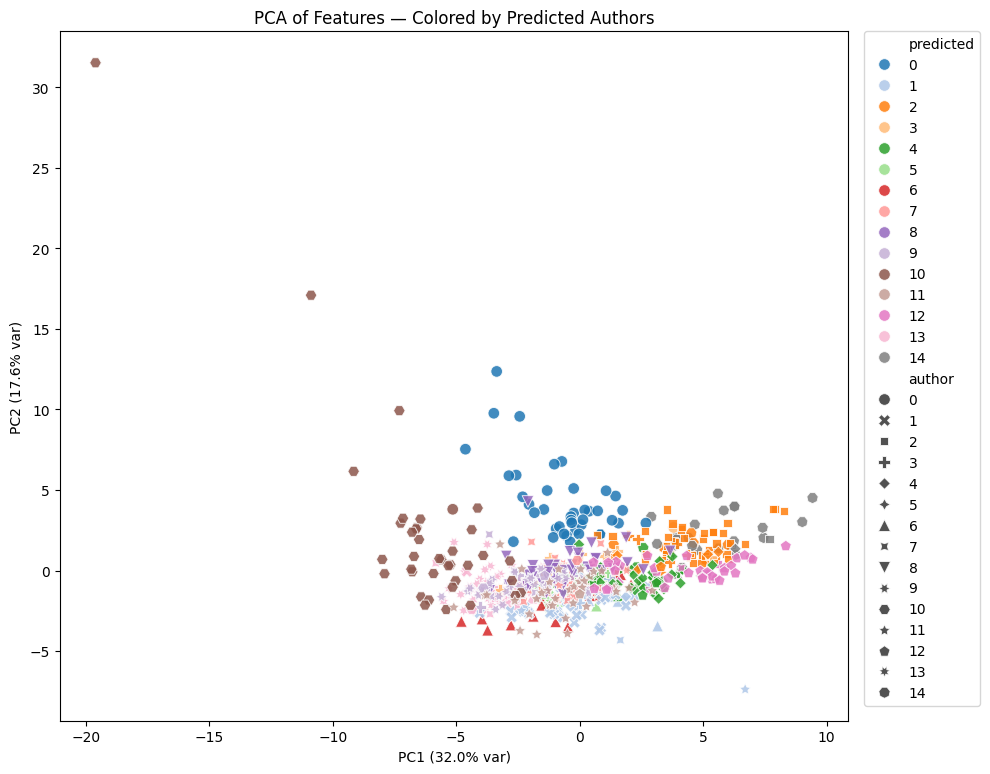

In [9]:
# -----------------------------
# PCA for visualization only
# -----------------------------
X_scaled = knn_pipeline.named_steps["scaler"].transform(X)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=numeric_df.index)
pc_df["author"] = y
pc_df["predicted"] = knn_pipeline.predict(X)

# -----------------------------
# Plot PCA scatter colored by predicted authors
# -----------------------------
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    hue="predicted",
    style="author",  # optional: differentiate true authors
    palette="tab20",
    s=70,
    alpha=0.85,
    edgecolor="w"
)
explained = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
ax.set_title("PCA of Features — Colored by Predicted Authors")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

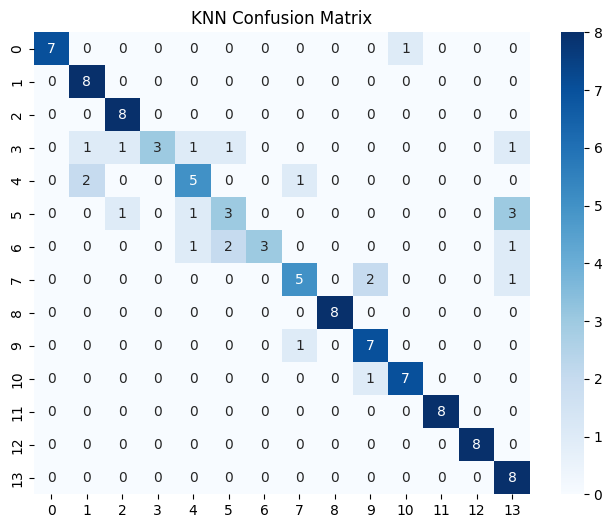

In [10]:
report = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
df_report = pd.DataFrame(report)

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
plt.title("KNN Confusion Matrix")
plt.savefig("output/KNN_classification.png")
plt.show()

### Random Forest

In [11]:
# -----------------------------
# RF pipeline (all features)
# -----------------------------
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42))
])

# Train KNN
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8
           2       0.89      1.00      0.94         8
           3       0.83      0.62      0.71         8
           4       0.88      0.88      0.88         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       0.88      0.88      0.88         8
           8       1.00      1.00      1.00         8
           9       0.88      0.88      0.88         8
          10       0.78      0.88      0.82         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       0.80      1.00      0.89         8
          14       1.00      0.75      0.86         8

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.91       1

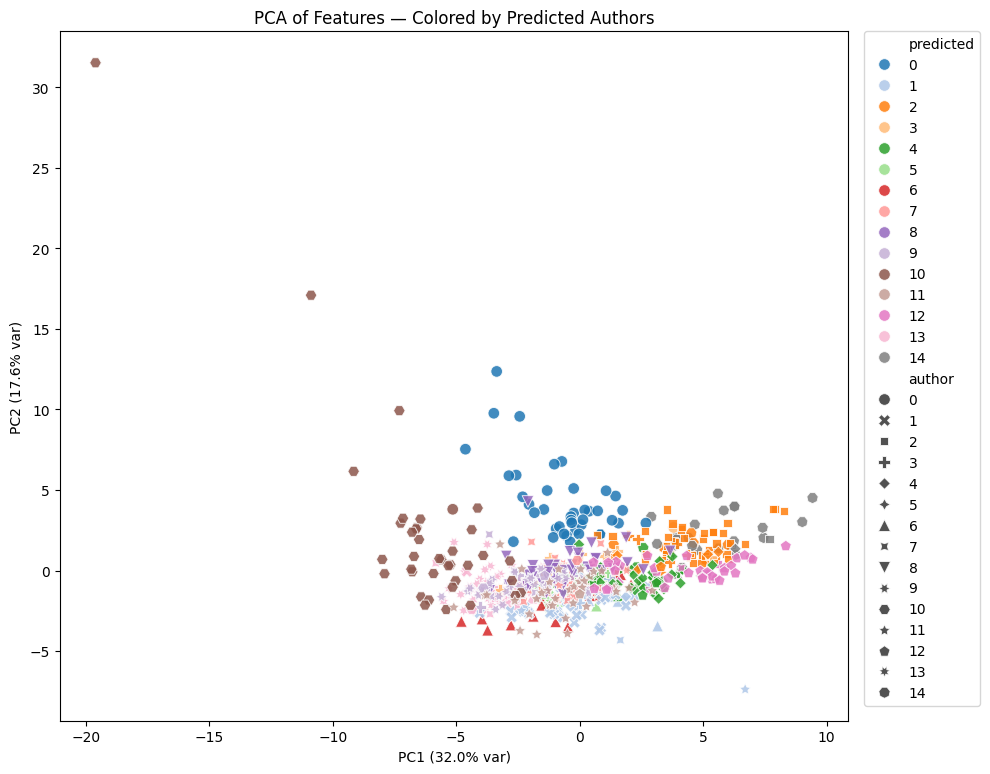

In [12]:
# -----------------------------
# PCA for visualization only
# -----------------------------
X_scaled = rf_pipeline.named_steps["scaler"].transform(X)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=numeric_df.index)
pc_df["author"] = y
pc_df["predicted"] = knn_pipeline.predict(X)

# -----------------------------
# Plot PCA scatter colored by predicted authors
# -----------------------------
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    hue="predicted",
    style="author",  # optional: differentiate true authors
    palette="tab20",
    s=70,
    alpha=0.85,
    edgecolor="w"
)
explained = pca.explained_variance_ratio_
ax.set_xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
ax.set_title("PCA of Features — Colored by Predicted Authors")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

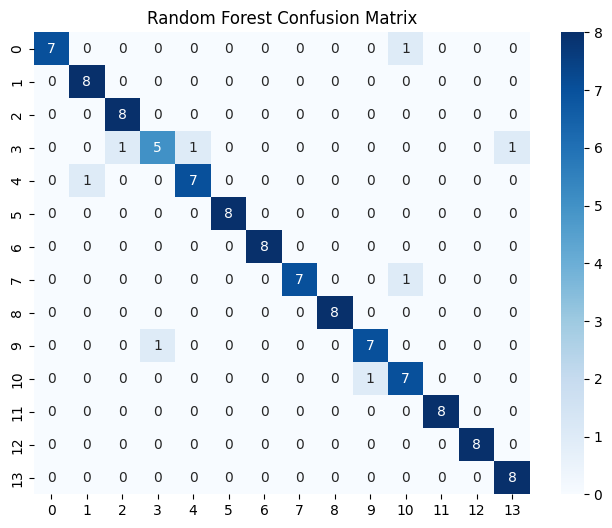

In [13]:
report = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
df_report = pd.DataFrame(report)

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
plt.title("Random Forest Confusion Matrix")
plt.savefig("output/RF_classification.png")
plt.show()

### Neural Network

In [14]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

num_classes = len(le.classes_)

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [15]:
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(num_classes, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', #val_loss
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=175,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1750 - loss: 2.8107 - val_accuracy: 0.4000 - val_loss: 1.8403
Epoch 2/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3417 - loss: 2.0800 - val_accuracy: 0.5083 - val_loss: 1.5189
Epoch 3/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4104 - loss: 1.8417 - val_accuracy: 0.6417 - val_loss: 1.2835
Epoch 4/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4896 - loss: 1.6282 - val_accuracy: 0.6667 - val_loss: 1.1613
Epoch 5/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4938 - loss: 1.6160 - val_accuracy: 0.6833 - val_loss: 1.1060
Epoch 6/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5396 - loss: 1.5558 - val_accuracy: 0.6583 - val_loss: 1.0882
Epoch 7/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 1.4653 - val_accuracy: 0.7750 - val_loss: 0.9793
Epoch 8/175
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5208 - loss: 1.4404 - val_accu

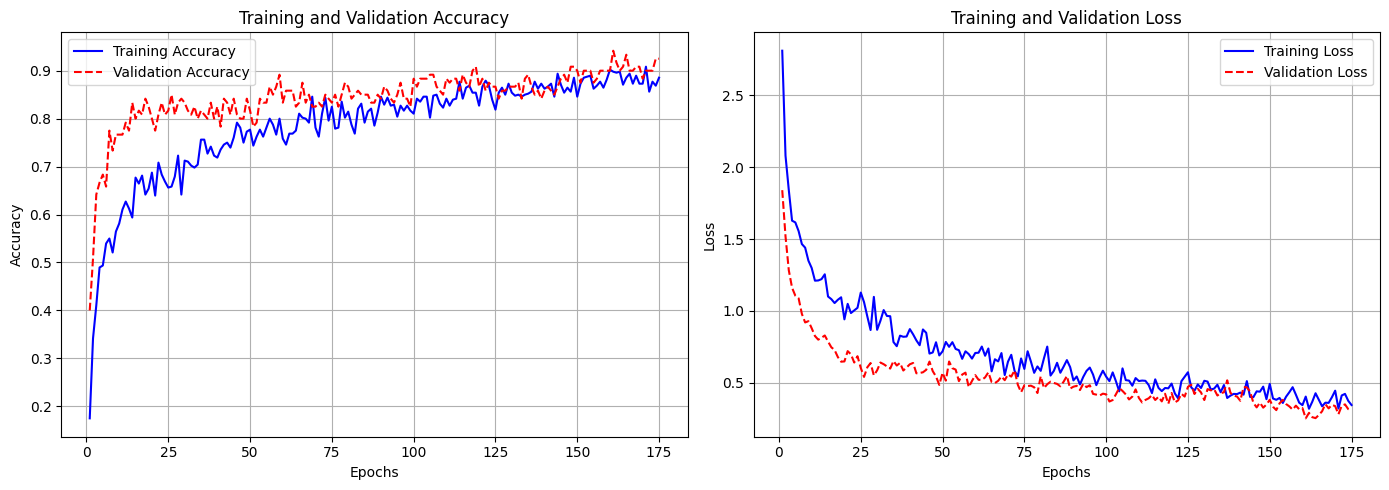

In [19]:
# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Loss
# -----------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("output/NN_training.png")
plt.show()

In [17]:
# -----------------------------
# Evaluate
# -----------------------------
loss, acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.3f}")

# Predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy: 0.942
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

     1151815       1.00      1.00      1.00         8
     1234212       1.00      1.00      1.00         8
     1476382       1.00      1.00      1.00         8
     1510754       1.00      0.75      0.86         8
     1604072       0.88      0.88      0.88         8
      215223       0.80      1.00      0.89         8
      216413       1.00      1.00      1.00         8
     2186817       0.86      0.75      0.80         8
     2587254       1.00      1.00      1.00         8
     2639424       0.89      1.00      0.94         8
     2822042       0.89      1.00      0.94         8
     2872565       1.00      1.00      1.00         8
     2922061       1.00      1.00      1.00         8
      470861       1.00      1.00      1.00         8
      554681       0.86      0.75      0.80         8

    accuracy                           0.94       120
   macro avg       0.

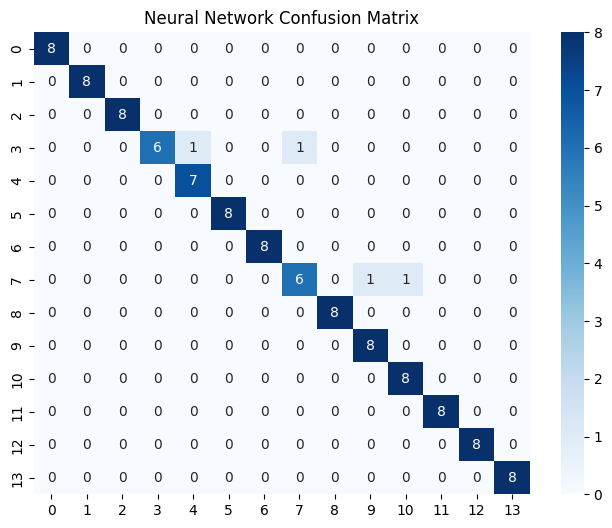

In [18]:
report = confusion_matrix(y_test, y_pred)

# Convert to DataFrame
df_report = pd.DataFrame(report)

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
plt.title("Neural Network Confusion Matrix")
plt.savefig("output/NN_classification.png")
plt.show()